ctrl + f for "speedup" to find improvement locations

## Bitboard implementation
## Bitboards
The chess board is implemented as a collection if bitboards. Bitboards are 64 bit representations of a chess board. They are int64s where the positions of set bits (positions of 1s) give information about the game state. Bitboards are memory efficient and allow fast bitwise operations to manipulate the board. This is a piece centric board representation.

Their memory efficiency allows for fast lookup tables. For example, a knight on a certain position on the board only has 8 or less moves. Instead of calculating each move, a lookup table is used to fetch all possible moves. A bitwise operation can be used to quickly evaluate the effects of each move.

Sliding pieces are more difficult, they require magic bitboards. A special kind of lookup table. 

## Move generation
For the move generation, a pseudo-legal move generator is used. This means that the generated moves could leave the king in check and this is only checked for afterwards.

## Definitions
Set bit: A bit is set if it has a value of 1. For example, in 0100, only the second bit is set.

Least significant bit: The bit that contributes the least to the value of the integer, in practice, this is the last bit. For example, in 0100, the least significant bit is the 0 at the end.

Attack board: A bitboard that shows all possible attacks for a specific piece in a specific location, without taking the color of the attacked position into account.  

## Operations
\>>: right shift operator, it performs a bitwise right shift operation on a number by a specified number of positions. For example a = 1010, a >> 2 = 10

## Notes
Black starts at the low indexes (0-16) and white on the high indexes (48-64)

## General functions

### Visualize a bitboard

In [ ]:
def print_bitboard(bitboard):
    """
    print a given bitboard, the occupied positions are represented by 'X', unoccupied positions are represented by '.'
    bitboard: a bitboard that needs to be visualized
    """
    # loop over the rows and columns of the board
    for row in range(8):
        row_str = ""
        for col in range(8):
            # check if the current square is occupied by a piece (check if the bit is set)
            if (bitboard >> (8*row + col)) & 1:
                # if the square is occupied, add an "X" to the string
                row_str += "X "
            else:
                # if the square is empty, add a "." to the string
                row_str += ". "
        # print the row string
        print(row_str)

In [1]:
# the starting game state, the convention in this engine is that the first 6 bitboards represent white, represented by 0
# white
white_pawn = int('0000000011111111000000000000000000000000000000000000000000000000', 2)
white_rook = int('1000000100000000000000000000000000000000000000000000000000000000', 2)
white_knight = int('0100001000000000000000000000000000000000000000000000000000000000', 2)
white_bishop = int('0010010000000000000000000000000000000000000000000000000000000000', 2)
white_queen = int('0000100000000000000000000000000000000000000000000000000000000000', 2)
white_king = int('0001000000000000000000000000000000000000000000000000000000000000', 2)

# black
black_pawn = int('0000000000000000000000000000000000000000000000001111111100000000', 2)
black_rook = int('0000000000000000000000000000000000000000000000000000000010000001', 2)
black_knight = int('0000000000000000000000000000000000000000000000000000000001000010', 2)
black_bishop = int('0000000000000000000000000000000000000000000000000000000000100100', 2)
black_queen = int('0000000000000000000000000000000000000000000000000000000000001000', 2)
black_king = int('0000000000000000000000000000000000000000000000000000000000010000', 2)

# en passant
white_en_passant = 0
black_en_passant = 0

# castling_rights
white_long_castle = True
white_short_castle = True
black_long_castle = True
black_short_castle = True

initial_game_state = [white_pawn, white_rook, white_knight, white_bishop, white_queen, white_king, black_pawn, black_rook, black_knight, black_bishop, black_queen, black_king, white_en_passant, black_en_passant, white_long_castle, white_short_castle, black_long_castle, black_short_castle]

In [2]:
# visualization of one of the 12 starting bitboards
print_bitboard(white_knight)

NameError: name 'print_bitboard' is not defined

### Get a bitboard of all pieces of one color

In [ ]:
from functools import reduce
from operator import or_

def get_all_color(state):
    """
    get a bitboard of all pieces of a color
    state: current game state, a list of 12 bitboards
    color: desired color
    """
    
    white_bb = reduce(or_, state[:6])
    black_bb = reduce(or_, state[6:12])
    return white_bb, black_bb

In [ ]:
# visualization of the function
print_bitboard(get_all_color(initial_game_state)[0])
print('---------------')
print_bitboard(get_all_color(initial_game_state)[1])

. . . . . . . . 
. . . . . . . . 
. . . . . . . . 
. . . . . . . . 
. . . . . . . . 
. . . . . . . . 
X X X X X X X X 
X X X X X X X X 
---------------
X X X X X X X X 
X X X X X X X X 
. . . . . . . . 
. . . . . . . . 
. . . . . . . . 
. . . . . . . . 
. . . . . . . . 
. . . . . . . . 


### Get a bitboard of all pieces

In [ ]:
from functools import reduce
from operator import or_

def get_occupancy(state):
    """
    get a bitboard of all pieces of both colors
    state: current game state, a list of 12 bitboards
    """
    
    occupancy_bb = reduce(or_, state[:12])
    return occupancy_bb

In [ ]:
# visualization of the function
print_bitboard(get_occupancy(initial_game_state))

X X X X X X X X 
X X X X X X X X 
. . . . . . . . 
. . . . . . . . 
. . . . . . . . 
. . . . . . . . 
X X X X X X X X 
X X X X X X X X 


## Knight

This section contains functions required to make the lookup table for knight attacks. When the engine is started, this lookup table is generated. Generating all possible knight attacks doesn't take long, but querying a table takes even less time.

To create the lookup table, a bitboard is generated for each position. This bitboard contains all possible destinations for the knight from the input position. 

- all 8 possible knight moves are added and checked to see if they stay within the bounds of the board
    - rankwise errors: verify if the destination is 0-63 suffices 
    - columnwise errors: check if the starting position is on the A or B file and the destination ends up in the G or H file and we check if the starting position is on the G or H file and the destination ends up in the A or B file. 
        - with bitwise operations comparing the position and destination bitboards with bitboards for the A and B file (hexadecimal: 0x0303030303030303) and the G and H file (hexadecimal: 0xC0C0C0C0C0C0C0C0).

In [ ]:
def get_knight_attack(position):
    """
    returns a bitboard with all the possible knight moves starting from the given position
    position: an integer (0-63) that gives the position of the knight.
    """
    
    # turn the position into a bitboard
    position_bb = 0
    position_bb |= 1 << position
    
    # positions for knight moves
    # these indicate what the possible positions of a knight are relative to a given position (input)
    knight_moves = [10, 17, 15, 6, -10, -17, -15, -6]
    
    # initialize bitboard
    attack_bb = 0
    # loop over the knight moves and add the corresponding squares to the bitboard
    for move in knight_moves:
        destination = position + move
        # turn the move into a bitboard
        # check for rankwise (rowwise) errors by checking if the destination is 0-63
        if destination >= 0 and destination < 64:
            # initialize temporary destination bitboard
            destination_bb = 0
            destination_bb |= 1 << destination
            # check for filewise (columnwise) errors
            # the first operation determines if the knight is on the A or B file (position_bb & 0x0303030303030303) or on the G or H file (position_bb & 0xC0C0C0C0C0C0C0C0)
            # so this: (position_bb & 0x0303030303030303) != 0 is true if the knight is on the A or B file
            # the second operation check if the destination is on the G or H file (dest_bb & 0xC0C0C0C0C0C0C0C0) or on the A or B file (dest_bb & 0x0303030303030303) to see if the knight crossed the board borders
            if not ((position_bb & 0x0303030303030303) != 0 and (destination_bb & 0xC0C0C0C0C0C0C0C0) != 0) and \
               not ((position_bb & 0xC0C0C0C0C0C0C0C0) != 0 and (destination_bb & 0x0303030303030303) != 0):
                # if the move is valid, set the corresponding bit in the bitboard
                attack_bb |= 1 << destination
    return attack_bb

In [ ]:
# create lookup table for knights
knight_table = []
for i in range(64):
    knight_table.append(get_knight_attack(i))

In [ ]:
# a demonstration of the knight move generation
print_bitboard(get_knight_attack(52))

. . . . . . . . 
. . . . . . . . 
. . . . . . . . 
. . . . . . . . 
. . . X . X . . 
. . X . . . X . 
. . . . . . . . 
. . X . . . X . 


## Rook

For sliding pieces, it's a bit more difficult to generate move sets. Knights don't have blocking pieces, which makes their lookup table simple. Sliding pieces need to take blocking pieces into account, resulting in large lookup tables.

This requires magic bitboards, which function as follows.

Start by generating a mask for a given piece at a given position, this mask is always the same for that given position, like the knight mask. The mask is all of the squares that can be occupied and block your piece from moving further, so edges don't need to be included

```
 A rook mask: 
0 0 0 0 0 0 0 0
0 0 0 0 1 0 0 0
0 0 0 0 1 0 0 0
0 0 0 0 1 0 0 0
0 1 1 1 0 1 1 0
0 0 0 0 1 0 0 0
0 0 0 0 1 0 0 0
0 0 0 0 0 0 0 0
```
 
Next we need to create a subset of this mask. This subset contains only the positions where there are blocking pieces. This is generated by an & operation between the rook mask and a bitboard that contains all pieces on the board, called the blocker board. The subset is called a masked blocker board.

```
 A rook mask             A blocker board       A masked blocker board  
0 0 0 0 0 0 0 0          0 0 0 0 0 0 0 0          0 0 0 0 0 0 0 0  
0 0 0 0 1 0 0 0          0 1 0 0 1 0 0 1          0 0 0 0 1 0 0 0  
0 0 0 0 1 0 0 0          1 0 0 0 0 0 0 0          0 0 0 0 0 0 0 0  
0 0 0 0 1 0 0 0          0 0 0 0 1 0 0 0          0 0 0 0 1 0 0 0  
0 1 1 1 0 1 1 0    &     0 1 1 0 0 0 0 0     =    0 1 1 0 0 0 0 0  
0 0 0 0 1 0 0 0          0 0 0 0 0 0 0 0          0 0 0 0 0 0 0 0  
0 0 0 0 1 0 0 0          1 0 0 0 1 0 1 0          0 0 0 0 1 0 0 0  
0 0 0 0 0 0 0 0          0 0 0 0 0 0 0 0          0 0 0 0 0 0 0 0  
```

This masked blocker board is mapped to an attack bitboard. This is done with a hash table using magic numbers.

```
A masked blocker board     An attack bitboard
   0 0 0 0 0 0 0 0           0 0 0 0 0 0 0 0 
   0 0 0 0 1 0 0 0           0 0 0 0 0 0 0 0 
   0 0 0 0 0 0 0 0           0 0 0 0 0 0 0 0 
   0 0 0 0 1 0 0 0           0 0 0 0 1 0 0 0 
   0 1 1 0 0 0 0 0    ->     0 0 1 1 0 1 1 1 
   0 0 0 0 0 0 0 0           0 0 0 0 1 0 0 0 
   0 0 0 0 1 0 0 0           0 0 0 0 1 0 0 0 
   0 0 0 0 0 0 0 0           0 0 0 0 0 0 0 0 
```

The resulting attack bitboard may include moves that capture your own pieces, however these moves are easily removed afterward: moveboard &= ~friendly_pieces)

There are many possible masked blocker boards, too many to use as keys, so they are hashed into a smaller key, which can be used to look up attack bitboards. To get a key, the masked blocker board is multiplied with a magic number, the result of this is shifted 54 bit positions (only the first 10 are kept) and that gives us the key. There is one magic number per square

```
A masked blocker board
   0 0 0 0 0 0 0 0
   0 0 0 0 1 0 0 0
   0 0 0 0 0 0 0 0
   0 0 0 0 1 0 0 0
   0 1 1 0 0 0 0 0       *    magic number = new number
   0 0 0 0 0 0 0 0
   0 0 0 0 1 0 0 0
   0 0 0 0 0 0 0 0
   
new number >> 54 = key
```

more info:
https://rhysre.net/fast-chess-move-generation-with-magic-bitboards.html 

To actually create this lookup table, do the following:
1. create a mask for each square (only 64 in total, not that complicated)
2. generate all possible masked blocker boards on each square
    - This is achieved by getting all subsets of the mask in this position
3. generate the attack bitboards for each masked blocker board
4. try random integers and check if they are magic
    - a magic number is magic if it maps each masked blocker board to a unique attack board (or if it maps different blocker boards to the same, correct attack board)

more info:
https://stackoverflow.com/questions/16925204/sliding-move-generation-using-magic-bitboard
https://www.chessprogramming.net/generating-magic-multipliers/

In [ ]:
def get_rook_mask(position):
    """
    returns a bitboard with all the positions that could block a rook given the position of the rook
    position: an integer (0-63) that gives the position of the rook
    """

    # initialize mask
    mask_bb = 0
    
    #look above the rook
    north_destination = position - 8
    while north_destination >= 8:
        mask_bb |= 1 << north_destination
        north_destination -= 8
        
    #look below the rook
    south_destination = position + 8
    while south_destination < 56:
        mask_bb |= 1 << south_destination
        south_destination += 8
        
    #look left of the rook
    west = position%8
    for i in range(west - 1):
        mask_bb |= 1 << position - (i + 1)
        
    #look right of the rook
    east = 8 - position%8
    for i in range(east - 2):
        mask_bb |= 1 << position + (i + 1)
        
    return mask_bb

In [ ]:
# a demonstration of rook mask generation
print_bitboard(get_rook_mask(0))

. X X X X X X . 
X . . . . . . . 
X . . . . . . . 
X . . . . . . . 
X . . . . . . . 
X . . . . . . . 
X . . . . . . . 
. . . . . . . . 


In [ ]:
from itertools import combinations

def get_masked_blocker_boards(position, mask_bb):
    """
    generate all possible blocker boards for a given position and blocker board
    usable for both rook and bishop
    position: integer position for which we create blocker boards
    """
    
    # initialize output
    masked_blocker_boards_bb_list = [0]
    
    # get the integer positions of the set bits in the mask
    integer_positions = []
    for i in range(64):
        if (mask_bb >> i) & 1:
            integer_positions.append(i)
            
    # calculate all possible combinations of positions
    position_combinations = sum(map(lambda r: list(combinations(integer_positions, r)), range(1, len(integer_positions)+1)), [])
    
    # turn the integer positions into blockerboards again
    for position_combination in position_combinations:
        masked_blocker_board = 0
        for position in position_combination:
            masked_blocker_board |= 1 << position
        masked_blocker_boards_bb_list.append(masked_blocker_board)
        
    return masked_blocker_boards_bb_list

In [ ]:
# a demonstration of masked blocker board generation
mask_bb = get_rook_mask(20)
masked_bbs = get_masked_blocker_boards(20, mask_bb)
print(masked_bbs)
print_bitboard(masked_bbs[500])

[0, 4096, 131072, 262144, 524288, 2097152, 4194304, 268435456, 68719476736, 17592186044416, 4503599627370496, 135168, 266240, 528384, 2101248, 4198400, 268439552, 68719480832, 17592186048512, 4503599627374592, 393216, 655360, 2228224, 4325376, 268566528, 68719607808, 17592186175488, 4503599627501568, 786432, 2359296, 4456448, 268697600, 68719738880, 17592186306560, 4503599627632640, 2621440, 4718592, 268959744, 68720001024, 17592186568704, 4503599627894784, 6291456, 270532608, 68721573888, 17592188141568, 4503599629467648, 272629760, 68723671040, 17592190238720, 4503599631564800, 68987912192, 17592454479872, 4503599895805952, 17660905521152, 4503668346847232, 4521191813414912, 397312, 659456, 2232320, 4329472, 268570624, 68719611904, 17592186179584, 4503599627505664, 790528, 2363392, 4460544, 268701696, 68719742976, 17592186310656, 4503599627636736, 2625536, 4722688, 268963840, 68720005120, 17592186572800, 4503599627898880, 6295552, 270536704, 68721577984, 17592188145664, 4503599629471

In [ ]:
def get_rook_attack(position, rook_masked_blocker_bb):
    """
    calculates the attack bitboard for a given masked blocker bitboard for the rook
    position: integer position of the rook
    rook_masked_blocker_bb: a masked blocker bitboard for the given position
    """
    
    # initialize attack bitboard
    attack_bb = 0
    
    #look above the rook
    north_destination = position - 8
    while north_destination >= 0:
        north_destination_bb = 0
        north_destination_bb |= 1 << north_destination
        if rook_masked_blocker_bb & north_destination_bb == 0:
            attack_bb |= 1 << north_destination
        else:
            attack_bb |= 1 << north_destination
            break
        north_destination -= 8
        
    #look below the rook
    south_destination = position + 8
    while south_destination < 64:
        south_destination_bb = 0
        south_destination_bb |= 1 << south_destination
        if rook_masked_blocker_bb & south_destination_bb == 0:
            attack_bb |= 1 << south_destination
        else:
            attack_bb |= 1 << south_destination
            break
        south_destination += 8
        
    #look left of the rook
    west = position%8
    for i in range(west):
        west_destination = position - (i + 1)
        west_destination_bb = 0
        west_destination_bb |= 1 << west_destination
        if rook_masked_blocker_bb & west_destination_bb == 0:
            attack_bb |= 1 << west_destination
        else:
            attack_bb |= 1 << west_destination
            break
        
    #look right of the rook
    east = 8 - position%8
    for i in range(east - 1):
        east_destination = position + (i + 1)
        east_destination_bb = 0
        east_destination_bb |= 1 << east_destination
        if rook_masked_blocker_bb & east_destination_bb == 0:
            attack_bb |= 1 << east_destination
        else:
            attack_bb |= 1 << east_destination
            break
    
    return attack_bb

In [ ]:
# a demonstration of attack board generation
position = 20
mask_bb = get_rook_mask(position)
masked_bbs = get_masked_blocker_boards(position, mask_bb)
print_bitboard(masked_bbs[500])
print('---------------')
print_bitboard(get_rook_attack(position, masked_bbs[500]))

. . . . . . . . 
. . . . X . . . 
. . . . . X X . 
. . . . . . . . 
. . . . X . . . 
. . . . X . . . 
. . . . . . . . 
. . . . . . . . 
---------------
. . . . . . . . 
. . . . X . . . 
X X X X . X . . 
. . . . X . . . 
. . . . X . . . 
. . . . . . . . 
. . . . . . . . 
. . . . . . . . 


In [ ]:
def count_set_bits(bb):
    """
    Implementation of the Brian Kernighan's algorithm for counting set bits
    bb: bitboard
    """
    
    count = 0
    while(bb):
        bb &= (bb - 1)
        count += 1
        
    return count

In [ ]:
import random

def generate_rook_magicks(position):
    """
    generate a magic number for the rook for a given position
    position: integer position for which we want to generate a magic number
    """
    
    # get the mask for the given position
    mask_bb = get_rook_mask(position)
    
    # get all masked blocker boards for the given position
    masked_blocker_bb_list = get_masked_blocker_boards(position, mask_bb)
    
    # get all attack boards
    attack_bb_list = []
    for masked_blocker_bb in masked_blocker_bb_list:
        attack_bb_list.append(get_rook_attack(position, masked_blocker_bb))
        
    # initialize lookup table
    index_bits = count_set_bits(mask_bb)
    table = {}
        
    for j in range(100000000000):
        # generate a candidate magick number, combine multiple random numbers to decrease the amount of set bits
        magic = (random.randint(0, 0xFFFFFFFF) << 32) | random.randint(0, 0xFFFFFFFF) & (random.randint(0, 0xFFFFFFFF) << 32) | random.randint(0, 0xFFFFFFFF)
        found = False
        
        for i in range(len(masked_blocker_bb_list)):
            hashed = masked_blocker_bb_list[i] * magic
            index = (hashed >> (64 - index_bits))
            if index not in table.keys():
                table[index] = attack_bb_list[i]
            elif table[index] != attack_bb_list[i]:
                break
            
            if i == len(masked_blocker_bb_list) - 1:
                found = True
                break
        if found == True:
            break
    return magic, table

In [ ]:
print_bitboard(0xFFFF)

X X X X X X X X 
X X X X X X X X 
. . . . . . . . 
. . . . . . . . 
. . . . . . . . 
. . . . . . . . 
. . . . . . . . 
. . . . . . . . 


In [ ]:
# generate magic numbers and their accompanying lookup tables
rook_magics = []
rook_tables = []
for i in range(64):
    magic, table = generate_rook_magicks(i)
    rook_magics.append(magic)
    rook_tables.append(table)

## Bishop

The same things go for the bishop.

In [ ]:
def get_bishop_mask(position):
    """
    returns a bitboard with all the positions that could block a bishop given the position of the bishop
    position: an integer (0-63) that gives the position of the bishop
    """
    
    # initialize bitboard
    mask_bb = 0
    
    # look left-above the bishop
    # reduce values by 9, untill A or H file is reached
    north_west_destination = position - 9
    while north_west_destination >= 9:
        position_bb = 0
        position_bb |= 1 << north_west_destination
        if (position_bb & 0x8181818181818181) == 0:
            mask_bb |= 1 << north_west_destination
        else:
            break
        north_west_destination -= 9
            
    # look left-below the bishop
    # increase values by 7, untill A or H file is reached
    south_west_destination = position + 7
    while south_west_destination < 56:
        position_bb = 0
        position_bb |= 1 << south_west_destination
        if (position_bb & 0x8181818181818181) == 0:
            mask_bb |= 1 << south_west_destination
        else:
            break
        south_west_destination += 7
            
    # look right-above the bishop
    # reduce values by 7, untill A or H file is reached
    north_east_destination = position - 7
    while north_east_destination >= 9:
        position_bb = 0
        position_bb |= 1 << north_east_destination
        if (position_bb & 0x8181818181818181) == 0:
            mask_bb |= 1 << north_east_destination
        else:
            break
        north_east_destination -= 7
            
    # look right-below the bishop
    # increase values by 9, untill A or H file is reached
    south_east_destination = position + 9
    while south_east_destination < 56:
        position_bb = 0
        position_bb |= 1 << south_east_destination
        if (position_bb & 0x8181818181818181) == 0:
            mask_bb |= 1 << south_east_destination
        else:
            break
        south_east_destination += 9
            
    return mask_bb

In [ ]:
# a demonstration of bishop mask generation
print_bitboard(get_bishop_mask(40))

. . . . . . . . 
. . . . X . . . 
. . . X . . . . 
. . X . . . . . 
. X . . . . . . 
. . . . . . . . 
. X . . . . . . 
. . . . . . . . 


In [ ]:
# a demonstration of masked blocker board generation
mask_bb = get_bishop_mask(40)
masked_bbs = get_masked_blocker_boards(40, mask_bb)
print(masked_bbs)
print_bitboard(masked_bbs[10])

[0, 4096, 524288, 67108864, 8589934592, 562949953421312, 528384, 67112960, 8589938688, 562949953425408, 67633152, 8590458880, 562949953945600, 8657043456, 562950020530176, 562958543355904, 67637248, 8590462976, 562949953949696, 8657047552, 562950020534272, 562958543360000, 8657567744, 562950021054464, 562958543880192, 562958610464768, 8657571840, 562950021058560, 562958543884288, 562958610468864, 562958610989056, 562958610993152]
. . . . . . . . 
. . . . . . . . 
. . . X . . . . 
. . X . . . . . 
. . . . . . . . 
. . . . . . . . 
. . . . . . . . 
. . . . . . . . 


In [ ]:
print_bitboard(0xFF818181818181FF)

X X X X X X X X 
X . . . . . . X 
X . . . . . . X 
X . . . . . . X 
X . . . . . . X 
X . . . . . . X 
X . . . . . . X 
X X X X X X X X 


In [ ]:
def get_bishop_attack(position, bishop_masked_blocker_bb):
    """
    calculates the attack bitboard for a given masked blocker bitboard for the bishop
    position: integer position of the bishop
    bishop_masked_blocker_bb: a masked blocker bitboard for the given position
    """
    
    # initialize attack bitboard
    attack_bb = 0

    # look left-above the bishop
    # reduce values by 9, untill A or H file is reached
    # only if the bishop isn't on the left file or top rank
    if ((position > 7) & (position % 8 != 0)):
        north_west_destination = position - 9
        position_bb = 0
        position_bb |= 1 << north_west_destination
        while (((bishop_masked_blocker_bb & position_bb) == 0) & ((position_bb & 0xFF818181818181FF) == 0)):
            attack_bb |= 1 << north_west_destination
            north_west_destination -= 9
            position_bb |= 1 << north_west_destination
        attack_bb |= 1 << north_west_destination
            
    # look left-below the bishop
    # increase values by 7, untill A or H file is reached
    if ((position < 56) & (position % 8 != 0)):
        south_west_destination = position + 7
        position_bb = 0
        position_bb |= 1 << south_west_destination
        while (((bishop_masked_blocker_bb & position_bb) == 0) & ((position_bb & 0xFF818181818181FF) == 0)):
            attack_bb |= 1 << south_west_destination
            south_west_destination += 7
            position_bb |= 1 << south_west_destination
        attack_bb |= 1 << south_west_destination
            
    # look right-above the bishop
    # reduce values by 7, untill A or H file is reached
    if ((position > 7) & ((position + 1) % 8 != 0)):
        north_east_destination = position - 7
        position_bb = 0
        position_bb |= 1 << north_east_destination
        while (((bishop_masked_blocker_bb & position_bb) == 0) & ((position_bb & 0xFF818181818181FF) == 0)):
            attack_bb |= 1 << north_east_destination
            north_east_destination -= 7
            position_bb |= 1 << north_east_destination
        attack_bb |= 1 << north_east_destination
            
    # look right-below the bishop
    # increase values by 9, untill A or H file is reached
    if ((position < 56) & ((position + 1) % 8 != 0)):
        south_east_destination = position + 9
        position_bb = 0
        position_bb |= 1 << south_east_destination
        while (((bishop_masked_blocker_bb & position_bb) == 0) & ((position_bb & 0xFF818181818181FF) == 0)):
            attack_bb |= 1 << south_east_destination
            south_east_destination += 9
            position_bb |= 1 << south_east_destination
        attack_bb |= 1 << south_east_destination
            
    return attack_bb

In [ ]:
# a demonstration of attack board generation
position = 25
mask_bb = get_bishop_mask(position)
masked_bbs = get_masked_blocker_boards(position, mask_bb)
print(masked_bbs)
print_bitboard(masked_bbs[30])
print('---------------')
print_bitboard(get_bishop_attack(position, masked_bbs[30]))

print(masked_bbs[30] & get_bishop_attack(position, masked_bbs[30]))

[0, 2048, 262144, 17179869184, 8796093022208, 4503599627370496, 264192, 17179871232, 8796093024256, 4503599627372544, 17180131328, 8796093284352, 4503599627632640, 8813272891392, 4503616807239680, 4512395720392704, 17180133376, 8796093286400, 4503599627634688, 8813272893440, 4503616807241728, 4512395720394752, 8813273153536, 4503616807501824, 4512395720654848, 4512412900261888, 8813273155584, 4503616807503872, 4512395720656896, 4512412900263936, 4512412900524032, 4512412900526080]
. . . . . . . . 
. . . . . . . . 
. . X . . . . . 
. . . . . . . . 
. . X . . . . . 
. . . X . . . . 
. . . . X . . . 
. . . . . . . . 
---------------
. . . . . . . . 
. . . . . . . . 
X . X . . . . . 
. . . . . . . . 
X . X . . . . . 
. . . . . . . . 
. . . . . . . . 
. . . . . . . . 
17180131328


In [ ]:
import random

def generate_bishop_magicks(position):
    """
    generate a magic number for the bishop for a given position
    position: integer position for which we want to generate a magic number
    """
    
    # get the mask for the given position
    mask_bb = get_bishop_mask(position)
    
    # get all masked blocker boards for the given position
    masked_blocker_bb_list = get_masked_blocker_boards(position, mask_bb)
    
    # get all attack boards
    attack_bb_list = []
    for masked_blocker_bb in masked_blocker_bb_list:
        attack_bb_list.append(get_bishop_attack(position, masked_blocker_bb))
        
    # initialize lookup table
    index_bits = count_set_bits(mask_bb)
    table = {}
        
    for j in range(100000000000):
        # generate a candidate magick number, combine multiple random numbers to decrease the amount of set bits
        magic = (random.randint(0, 0xFFFFFFFF) << 32) | random.randint(0, 0xFFFFFFFF) & (random.randint(0, 0xFFFFFFFF) << 32) | random.randint(0, 0xFFFFFFFF)
        found = False
        
        for i in range(len(masked_blocker_bb_list)):
            hashed = masked_blocker_bb_list[i] * magic
            index = (hashed >> (64 - index_bits))
            if index not in table.keys():
                table[index] = attack_bb_list[i]
            elif table[index] != attack_bb_list[i]:
                break
            
            if i == len(masked_blocker_bb_list) - 1:
                found = True
                break
        if found == True:
            break
    return magic, table

In [ ]:
# generate magic numbers and their accompanying lookup tables
bishop_magics = []
bishop_tables = []
for i in range(64):
    magic, table = generate_bishop_magicks(i)
    bishop_magics.append(magic)
    bishop_tables.append(table)

In [ ]:
print(bishop_tables[58])

{0: 2833579985862656, 2421483820: 2833579977474048, 309949928990: 2833578903732224, 39673590910798: 2833441464778752, 1269554909145564: 2832480474234880, 5078219636582257: 2815849278734336, 312371412810: 2833578903732224, 39676012394619: 2833441464778752, 1269557330629384: 2832480465846272, 5078222058066077: 2815849278734336, 39983540839789: 2833441464778752, 1269864859074554: 2832479392104448, 5078529586511247: 2815849278734336, 1309228500056363: 2832341953150976, 5117893227493056: 2815849278734336, 6347774545727821: 2814749767106560, 39985962323609: 2833441464778752, 1269867280558375: 2832479392104448, 5078532007995068: 2815849278734336, 1309230921540183: 2832341953150976, 5117895648976876: 2815849278734336, 6347776967211641: 2814749767106560, 1309538449985353: 2832341953150976, 5118203177422046: 2815849278734336, 6348084495656812: 2814749767106560, 6387448136638620: 2814749767106560, 1309540871469174: 2832341953150976, 5118205598905866: 2815849278734336, 6348086917140632: 2814749767

why are magic numbers better than just using masked blocker boards as indexes? how is it faster????

## Pawn

The pawn gets two move board generator functions, one for attacks and one for normal moves. The one for normal moves is used to create two lookup tables, one for unblocked pawns and one for blocked pawns. 
- There is a need to check for rankwise errors, even though pawns can never be on the last rank. The current implementation has an output for every position index
- No need to check for filewise errors, this function doesn't allow for sideways movement
- The numerical position is used as an index, meaning that some parts of the lookup table should never be used in a real game

The one for attacks creates one lookup table. It generates diagonal moves whose validity are checked during runtime by checking if they correspond with an enemy piece.

In [ ]:
def get_pawn_move(position, color, blocked):
    """
    returns a bitboard with one or two squares in front of the pawn set.
    position: an integer (0-63) that gives the position of the pawn
    color: an integer that represents the color of the pawn
    blocked: a boolean that indicates if the pawn is blocked or not
    """
    
    # turn the position into a bitboard
    position_bb = 0
    position_bb |= 1 << position
    
    # determine direction through color
    if color == 0:
        direction = -1
    else:
        direction = 1
    
    # position for the pawn moves
    # check if pawn is on starting rank
    if (48 - color*40) <= position and position < (56 - color*40) and blocked == False:
        pawn_moves = [8, 16]
    else:
        pawn_moves = [8]
    
    # initialize bitboard
    attack_bb = 0
    
    # loop over the pawn moves and add the corresponding squares to the bitboard
    for move in pawn_moves:
        destination = position + direction*move
        # check for rankwise (rowwise) errors by checking if the destination is 0-63 (this can't occur in chess, but the implementation calls for it)
        if destination >= 0 and destination < 64:
            # add to attack bitboard
            attack_bb |= 1 << destination
    return attack_bb

In [ ]:
# generate lookup tables
unblocked_pawn_move_table = [[], []]
blocked_pawn_move_table = [[], []]

# iterate over all board positions
for i in range(64):
    # iterate over both colors
    for j in range(2):
        unblocked_pawn_move_table[j].append(get_pawn_move(i, j, False))
        blocked_pawn_move_table[j].append(get_pawn_move(i, j, True))
        

In [ ]:
print_bitboard(unblocked_pawn_move_table[0][49])
print('-------------------')
print_bitboard(blocked_pawn_move_table[0][49])

. . . . . . . . 
. . . . . . . . 
. . . . . . . . 
. . . . . . . . 
. X . . . . . . 
. X . . . . . . 
. . . . . . . . 
. . . . . . . . 
-------------------
. . . . . . . . 
. . . . . . . . 
. . . . . . . . 
. . . . . . . . 
. . . . . . . . 
. X . . . . . . 
. . . . . . . . 
. . . . . . . . 


In [ ]:
def get_pawn_attack(position, color):
    """
    returns a bitboard with the two squares diagonally in front of the pawn set.
    position: an integer (0-63) that gives the position of the pawn.
    color: an integer that represents the color of the pawn
    """
    
    # turn the position into a bitboard
    position_bb = 0
    position_bb |= 1 << position
    
    # position for the pawn moves
    pawn_moves = [7, 9]
    
    # initialize bitboard
    attack_bb = 0
    
    # determine direction through color
    if color == 0:
        direction = -1
    else:
        direction = 1
    
    # loop over the pawn moves and add the corresponding squares to the bitboard
    for move in pawn_moves:
        destination = position + direction*move
        # turn the move into a bitboard
        # check for rankwise (rowwise) errors by checking if the destination is 0-63
        if destination >= 0 and destination < 64:
            # initialize temporary destination bitboard
            destination_bb = 0
            destination_bb |= 1 << destination
            # check for filewise (columnwise) errors
            # the first operation determines if the king is on the A file (position_bb & 0x0101010101010101) or on the H file (position_bb & 0x8080808080808080)
            # so this: (position_bb & 0x0101010101010101) != 0 is true if the king is on the A file
            # the second operation check if the destination is on the H file (dest_bb & 0x8080808080808080) or on the A file (dest_bb & 0x0101010101010101) to see if the king crossed the board borders
            if not ((position_bb & 0x0101010101010101) != 0 and (destination_bb & 0x8080808080808080) != 0) and \
               not ((position_bb & 0x8080808080808080) != 0 and (destination_bb & 0x0101010101010101) != 0):
                # if the move is valid, set the corresponding bit in the bitboard
                attack_bb |= 1 << destination
    return attack_bb

In [ ]:
# generate lookup tables
pawn_table = [[], []]

# iterate over all board positions
for i in range(64):
    # iterate over both colors
    for j in range(2):
        pawn_table[j].append(get_pawn_attack(i, j))

## King

The king can only move to 8 squares, like the knight, its attack bitboards are also stored in a lookup table that is generated at the initialization of the engine.

In [ ]:
def get_king_attack(position):
    """
    returns a bitboard with all the possible king moves starting from the given position
    position: an integer (0-63) that gives the position of the king.
    """
    
    # turn the position into a bitboard
    position_bb = 0
    position_bb |= 1 << position
    
    # positions for king moves
    # these indicate what the possible positions of a knight are relative to a given position (input)
    king_moves = [-9, -8, -7, -1, 1, 7, 8, 9]
    
    # initialize bitboard
    attack_bb = 0
    # loop over the king moves and add the corresponding squares to the bitboard
    for move in king_moves:
        destination = position + move
        # turn the move into a bitboard
        # check for rankwise (rowwise) errors by checking if the destination is 0-63
        if destination >= 0 and destination < 64:
            # initialize temporary destination bitboard
            destination_bb = 0
            destination_bb |= 1 << destination
            # check for filewise (columnwise) errors
            # the first operation determines if the king is on the A file (position_bb & 0x0101010101010101) or on the H file (position_bb & 0x8080808080808080)
            # so this: (position_bb & 0x0101010101010101) != 0 is true if the king is on the A file
            # the second operation check if the destination is on the H file (dest_bb & 0x8080808080808080) or on the A file (dest_bb & 0x0101010101010101) to see if the king crossed the board borders
            if not ((position_bb & 0x0101010101010101) != 0 and (destination_bb & 0x8080808080808080) != 0) and \
               not ((position_bb & 0x8080808080808080) != 0 and (destination_bb & 0x0101010101010101) != 0):
                # if the move is valid, set the corresponding bit in the bitboard
                attack_bb |= 1 << destination
    return attack_bb

In [ ]:
# create lookup table for the king
king_table = []
for i in range(64):
    king_table.append(get_king_attack(i))

In [ ]:
# a demonstration of the king move generation
print_bitboard(get_king_attack(0))

. X . . . . . . 
X X . . . . . . 
. . . . . . . . 
. . . . . . . . 
. . . . . . . . 
. . . . . . . . 
. . . . . . . . 
. . . . . . . . 


## Queen

The queen is a combination of a rook and a bishop, so its attack bitboard can be generated by a bitwise OR of both attack bitboards.

# Move generation
Now let's create a function to evaluate a piece. It takes the gamestate as bitboards as an input and outputs a move class object

perft debugging
move generation: https://www.chessprogramming.org/Move_Generation

mailbox -> bitboard
iterate over bbs
iterate over all bits
bitboard -> mailbox

https://www.cs.vu.nl/~wanf/theses/bijl-tiet-bscthesis.pdf
page 8

https://chess.stackexchange.com/questions/39910/how-do-chess-bitboards-generate-individual-moves 
https://stackoverflow.com/questions/72296626/chess-bitboard-move-generation 
https://www.chess.com/blog/the_real_greco/move-finding-the-engine-way 

In [ ]:
def pop_lsb(bb):
    """
    Returns the index, counting from 0, of the least significant set bit in a bitboard and returns the bitboard with the least significant bit removed
    bb: bitboard of which the least significant bit is popped
    """
    lsb = (bb&-bb).bit_length()-1
    popped_bb = (bb & ~(1 << lsb))
    return lsb, popped_bb

In [ ]:
from dataclasses import dataclass

# dataclass that represents a move
@dataclass()
class Move:
    """
    Class that contains information that specifies a move
    """
    piece_index: int
    from_square: int
    to_square: int
    promotion: int
    en_passantable: bool
    castling: bool

In [ ]:
def attacked(position, state, color):
    """
    Return a bool that tells whether the given position is attacked in the given game state by the opposing color
    position: an integer (0-63) that gives the position
    state: list of game state bitboards
    color: the color of the defending player
    """
    
    # initialize bitboard that contains all attacked positions
    all_attacked_bb = 0
    
    # turn position into a bitboard
    position_bb = 0
    position_bb |= 1 << position
    
    # get opponents color
    if color == 0:
        oppo_color = 1
    else:
        oppo_color = 0
    
    # iterate over all state bitboards
    for i in range(12):                                                                       ## iterate only over relevant bitboards for speedup
        bb = state[i]
        # get integer indexes of all pieces
        # by finding the least significant bit
        # returns index of least significant set bit
        integer_positions = []
        while bb != 0:
            lsb, bb = pop_lsb(bb)
            integer_positions.append(lsb)
                
        # iterate over all pieces
        for ipos in integer_positions:
            # initialize
            attack_bb = 0
            
            # pawn
            if i == (6 - 6*color):
                # get attack bitboard
                attack_bb = pawn_table[oppo_color][ipos]
                
            # rook
            if i == (7 - 6*color):
                occupancy_bb = get_occupancy(state)
                rook_mask = get_rook_mask(ipos)
                occupancy_mask = occupancy_bb & rook_mask
                magic = rook_magics[ipos]
                index = occupancy_mask*magic >> (64 - count_set_bits(rook_mask))
                attack_bb = rook_tables[ipos][index]
                
            # knight
            if i == (8 - 6*color):
                attack_bb = knight_table[ipos]
                
            # bishop
            if i == (9 - 6*color):
                occupancy_bb = get_occupancy(state)
                bishop_mask = get_bishop_mask(ipos)
                occupancy_mask = occupancy_bb & bishop_mask
                magic = bishop_magics[ipos]
                index = occupancy_mask*magic >> (64 - count_set_bits(bishop_mask))
                attack_bb = bishop_tables[ipos][index]
                
            # queen
            if i == (10 - 6*color):
                occupancy_bb = get_occupancy(state)
                rook_mask = get_rook_mask(ipos)
                rook_occupancy_mask = occupancy_bb & rook_mask
                rook_magic = rook_magics[ipos]
                rook_index = rook_occupancy_mask*rook_magic >> (64 - count_set_bits(rook_mask))        # generate nr of bits once upon startup to speedup
                rook_attack_bb = rook_tables[ipos][rook_index]
                bishop_mask = get_bishop_mask(ipos)
                bishop_occupancy_mask = occupancy_bb & bishop_mask
                bishop_magic = bishop_magics[ipos]
                bishop_index = bishop_occupancy_mask*bishop_magic >> (64 - count_set_bits(bishop_mask))
                bishop_attack_bb = bishop_tables[ipos][bishop_index]
                attack_bb = rook_attack_bb | bishop_attack_bb
                
            # king
            if i == (11 - 6*color):
                attack_bb = king_table[ipos]
                
            # add attack_bb to the bitboard with all attacks
            all_attacked_bb = all_attacked_bb | attack_bb
    
    # check if position is attacked
    attacked = False
    if all_attacked_bb & position_bb != 0:
        attacked = True
        
    return attacked

In [ ]:
def move_generator(state, color):
    """
    Evaluate all possible moves a piece could make and return the pseudo-legal ones
    state: current game state, a list of 12 bitboards
    color: the color of the piece that wants to move
    """
    
    # iterate over all bitboards
    # iterate over all pieces
    # generate legal moves for the piece
    # create a new game state for the legal move
    
    # initialize move list
    possible_moves = []
    
    # iterate over all bitboards
    for i in range(12):                                          # only iterate over the attackers or initialize attack_bb
        attack_bb = 0
        bb = state[i]
        # get integer indexes of all pieces
        # by finding the least significant bit
        # returns index of least significant set bit
        integer_positions = []
        while bb != 0:
            lsb, bb = pop_lsb(bb)
            integer_positions.append(lsb)
                
        # iterate over all pieces
        for position in integer_positions:
            
            # set default promotion and en passant settings
            promotion = False
            en_passantable = False
            
            # pawn
            # position determines if there will be promotion
            if i == (0 + 6*color):
                # get attack bitboard
                potential_attack_bb = pawn_table[color][position]
                # only keep moves that capture an opponent
                occupancy_bb = get_occupancy(state)
                # OR on occupance and en passant bitboard, because they don't overlap
                filtered_attack_bb = potential_attack_bb & (occupancy_bb | state[13 - color])
                
                # get move bitboard
                
                # check if pawn is blocked
                # determine direction through color
                if color == 0:
                    direction = -1
                else:
                    direction = 1
                # determine location of potential blockage (shouldn't give out of range error, since a pawn can't be on the final rank)
                blockage_position = position + 8*direction
                # determine if pawn is blocked
                blockage_bb = 0
                blockage_bb |= 1 << blockage_position
                blocked = False
                if ((blockage_bb & occupancy_bb) != 0):
                    blocked = True
                
                # no forward move if blocked
                if blocked:
                    move_bb = 0 
                # check if the pawn is on the starting rank
                elif (((48 - color*40) <= position) and (position < (56 - color*40))):
                    # double move or not
                    # check if pawn is blocked for double move
                    # determine location of potential further blockage (shouldn't give out of range error, since a pawn is on the starting rank)
                    far_blockage_position = blockage_position + 8*direction
                    # determine if pawn is blocked
                    far_blockage_bb = 0
                    far_blockage_bb |= 1 << far_blockage_position
                    if ((far_blockage_bb & occupancy_bb) != 0):
                        move_bb = blocked_pawn_move_table[color][position]
                    else:
                        move_bb = unblocked_pawn_move_table[color][position]
                        en_passantable = True
                else:
                    move_bb = unblocked_pawn_move_table[color][position]
                    
                # check for promotion
                # check if pawn is on the one before last rank (this works, because if the pawn doesn't move, there is no move object, so the "promotion" bool doesn't go through)
                if (((8 + color*40) <= position) and (position < (16 + color*40))):
                    promotion = True    
                
                # get final attack_bb
                attack_bb = filtered_attack_bb | move_bb
                
            # rook
            if i == (1 + 6*color):
                occupancy_bb = get_occupancy(state)
                rook_mask = get_rook_mask(position)
                occupancy_mask = occupancy_bb & rook_mask
                magic = rook_magics[position]
                index = occupancy_mask*magic >> (64 - count_set_bits(rook_mask))
                attack_bb = rook_tables[position][index]
                
            # knight
            if i == (2 + 6*color):
                attack_bb = knight_table[position]
                
            # bishop
            if i == (3 + 6*color):
                occupancy_bb = get_occupancy(state)
                bishop_mask = get_bishop_mask(position)
                occupancy_mask = occupancy_bb & bishop_mask
                magic = bishop_magics[position]
                index = occupancy_mask*magic >> (64 - count_set_bits(bishop_mask))
                attack_bb = bishop_tables[position][index]
                
            # queen
            if i == (4 + 6*color):
                occupancy_bb = get_occupancy(state)                                                  ## generate once in the beginning for speedup
                rook_mask = get_rook_mask(position)
                rook_occupancy_mask = occupancy_bb & rook_mask
                rook_magic = rook_magics[position]
                rook_index = rook_occupancy_mask*rook_magic >> (64 - count_set_bits(rook_mask))        # generate nr of bits once upon startup to speedup
                rook_attack_bb = rook_tables[position][rook_index]
                bishop_mask = get_bishop_mask(position)
                bishop_occupancy_mask = occupancy_bb & bishop_mask
                bishop_magic = bishop_magics[position]
                bishop_index = bishop_occupancy_mask*bishop_magic >> (64 - count_set_bits(bishop_mask))
                bishop_attack_bb = bishop_tables[position][bishop_index]
                attack_bb = rook_attack_bb | bishop_attack_bb
                
            # king
            if i == (5 + 6*color):
                attack_bb = king_table[position]
            
            # filter out captures of own pieces
            attack_bb = attack_bb & ~ get_all_color(state)[color]                    ## generate once in the beginning for speedup

            # turn attack_bb into list of move objects
            while attack_bb != 0:
                target_location, attack_bb = pop_lsb(attack_bb)
                if en_passantable:
                    if abs(position - target_location) > 9:
                        possible_moves.append(Move(i, position, target_location, i, True, False))
                    else:
                        possible_moves.append(Move(i, position, target_location, i, False, False))
                elif promotion:
                    for prom_piece in [1, 2, 3, 4]:
                        possible_moves.append(Move(i, position, target_location, prom_piece + 6*color, False, False))
                else:
                    possible_moves.append(Move(i, position, target_location, i, False, False))
                        
    # castling
    # long castling
    if state[14 + 2*color]:
        lc_masks = []
        lc_masks.append((1 << 57) | (1 << 58) | (1 << 59))               ## generate once in the beginning for speedup there have to be two, one black one white
        lc_masks.append((1 << 1) | (1 << 2) | (1 << 3))
        # continue if there are no obstructions
        if ((occupancy_bb & lc_masks[color]) == 0):
            check_positions = [[], []]
            check_positions[0] = [58, 59, 60]
            check_positions[1] = [2, 3, 4]                                      ## generate once in the beginning for speedup
            in_check = False
            for check_pos in check_positions[color]:
                if attacked(check_pos, state, color):
                    in_check = True
            # long castling
            if not in_check:
                possible_moves.append(Move(5 + 6*color, 56 - 56*color, 59 - 56*color, False, False, True))       ## castling bool is set, position is used to see which castling it is
                    
    # short castling
    if state[15 + 2*color]:
        sc_masks = []
        sc_masks.append((1 << 61) | (1 << 62))                            ## generate once in the beginning for speedup there have to be two, one black one white
        sc_masks.append((1 << 5) | (1 << 6))
        # continue if there are no obstructions
        if ((occupancy_bb & sc_masks[color]) == 0):
            check_positions = [[], []]
            check_positions[0] = [60, 61, 62]
            check_positions[1] = [4, 5, 6]                                      ## generate once in the beginning for speedup
            in_check = False
            for check_pos in check_positions[color]:
                if attacked(check_pos, state, color):
                    in_check = True
            # short castling
            if not in_check:
                possible_moves.append(Move(5 + 6*color, 63 - 56*color, 61 - 56*color, False, False, True))       ## castling bool is set, position is used to see which castling it is
            
    return possible_moves

In [ ]:
lc_masks = []
lc_masks.append((1 << 60) | (1 << 61) | (1 << 62))               ## generate once in the beginning for speedup there have to be two, one black one white
lc_masks.append((1 << 4) | (1 << 5) | (1 << 6))

print_bitboard(lc_masks[0])
print('-------------------')
print_bitboard(lc_masks[1])
print(lc_masks[0])
print(lc_masks[1])

sc_masks = []
sc_masks.append((1 << 61) | (1 << 62))                            ## generate once in the beginning for speedup there have to be two, one black one white
sc_masks.append((1 << 5) | (1 << 6))

print_bitboard(sc_masks[0])
print('-------------------')
print_bitboard(sc_masks[1])
print(sc_masks[0])
print(sc_masks[1])

. . . . . . . . 
. . . . . . . . 
. . . . . . . . 
. . . . . . . . 
. . . . . . . . 
. . . . . . . . 
. . . . . . . . 
. . . . X X X . 
-------------------
. . . . X X X . 
. . . . . . . . 
. . . . . . . . 
. . . . . . . . 
. . . . . . . . 
. . . . . . . . 
. . . . . . . . 
. . . . . . . . 
8070450532247928832
112
. . . . . . . . 
. . . . . . . . 
. . . . . . . . 
. . . . . . . . 
. . . . . . . . 
. . . . . . . . 
. . . . . . . . 
. . . . . X X . 
-------------------
. . . . . X X . 
. . . . . . . . 
. . . . . . . . 
. . . . . . . . 
. . . . . . . . 
. . . . . . . . 
. . . . . . . . 
. . . . . . . . 
6917529027641081856
96


In [ ]:
moves = move_generator(initial_game_state, 0)
print(moves)
print(len(moves))

[Move(piece_index=0, from_square=48, to_square=32, promotion=0, en_passantable=True, castling=False), Move(piece_index=0, from_square=48, to_square=40, promotion=0, en_passantable=False, castling=False), Move(piece_index=0, from_square=49, to_square=33, promotion=0, en_passantable=True, castling=False), Move(piece_index=0, from_square=49, to_square=41, promotion=0, en_passantable=False, castling=False), Move(piece_index=0, from_square=50, to_square=34, promotion=0, en_passantable=True, castling=False), Move(piece_index=0, from_square=50, to_square=42, promotion=0, en_passantable=False, castling=False), Move(piece_index=0, from_square=51, to_square=35, promotion=0, en_passantable=True, castling=False), Move(piece_index=0, from_square=51, to_square=43, promotion=0, en_passantable=False, castling=False), Move(piece_index=0, from_square=52, to_square=36, promotion=0, en_passantable=True, castling=False), Move(piece_index=0, from_square=52, to_square=44, promotion=0, en_passantable=False, c

In [ ]:
print_bitboard(1 << 59)

. . . . . . . . 
. . . . . . . . 
. . . . . . . . 
. . . . . . . . 
. . . . . . . . 
. . . . . . . . 
. . . . . . . . 
. . . X . . . . 


In [ ]:
import copy

def apply_move(state, move):
    """
    Apply a move object to a gamestate bitboard
    state: current game state, a list of 12 bitboards
    move: the move object that is applied to the state
    """
    
    # initialize
    next_state = copy.deepcopy(state)
    
    # update castling rights
    # white king
    if move.piece_index == 5:
        next_state[14] = False
        next_state[15] = False
    # black king
    if move.piece_index == 11:
        next_state[16] = False
        next_state[17] = False
    # white rook:
    if ((move.piece_index == 1) & (move.from_square == 56)):
        next_state[14] = False
    if ((move.piece_index == 1) & (move.from_square == 63)):
        next_state[15] = False
    #######
    if move.to_square == 56:
        next_state[14] = False
    if move.to_square == 63:
        next_state[15] = False
    ############
    # black rook:
    if ((move.piece_index == 7) & (move.from_square == 0)):
        next_state[16] = False
    if ((move.piece_index == 7) & (move.from_square == 7)):
        next_state[17] = False
    ###################
    if move.to_square == 0:
        next_state[16] = False
    if move.to_square == 7:
        next_state[17] = False
    #################
    
    # castling
    if move.castling:
        # white long castling
        if move.from_square == 56:
            # update king bitboard
            next_state[5] = 1 << 58
            # update rook bitboard
            
            remove_mask = 1 << move.from_square
            add_mask = 1 << 59
            # XOR to remove the piece
            next_state[1] = next_state[1] ^ remove_mask
            # AND to add the piece
            next_state[1] = next_state[1] | add_mask
            
        # black long castling
        elif move.from_square == 0:
            # update king bitboard
            next_state[11] = 1 << 2
            # update rook bitboard
            
            remove_mask = 1 << move.from_square
            add_mask = 1 << 3
            # XOR to remove the piece
            next_state[7] = next_state[7] ^ remove_mask
            # AND to add the piece
            next_state[7] = next_state[7] | add_mask
            
        # white short castling
        elif move.from_square == 63:
            # update king bitboard
            next_state[5] = 1 << 62
            # update rook bitboard
            
            remove_mask = 1 << move.from_square
            add_mask = 1 << 61
            # XOR to remove the piece
            next_state[1] = next_state[1] ^ remove_mask
            # AND to add the piece
            next_state[1] = next_state[1] | add_mask
            
        # black short castling
        elif move.from_square == 7:
            # update king bitboard
            next_state[11] = 1 << 6
            # update rook bitboard
            
            remove_mask = 1 << move.from_square
            add_mask = 1 << 5
            # XOR to remove the piece
            next_state[7] = next_state[7] ^ remove_mask
            # AND to add the piece
            next_state[7] = next_state[7] | add_mask
            
    # normal move
    else:
        remove_mask = 1 << move.from_square
        add_mask = 1 << move.to_square
        # XOR to remove the piece
        next_state[move.piece_index] = next_state[move.piece_index] ^ remove_mask
        
        # AND to add the piece
        next_state[move.promotion] = next_state[move.promotion] | add_mask
        
        # remove opponents piece
        # check if an opponent piece has been captured
        # get opponent bbs
        if move.piece_index < 6:
            opponent_pieces = [6, 7, 8, 9, 10, 11]
            en_passant_index = 13
        else:
            opponent_pieces = [0, 1, 2, 3, 4, 5]
            en_passant_index = 12
            
        target_bb = 1 << move.to_square
        for opponent_piece in opponent_pieces:
            next_state[opponent_piece] = next_state[opponent_piece] & ~(next_state[opponent_piece] & target_bb) 

        # en passant removal of pieces
        # only possible for a pawn
        if ((move.piece_index == 0) | (move.piece_index == 6)):
            if target_bb == next_state[en_passant_index]:
                en_passant_mask = 1 << (move.to_square - 8 - 16*(12-en_passant_index))
                # remove en passanted pawn
                next_state[-6*(12 - en_passant_index)] = next_state[-6*(12 - en_passant_index)] ^ en_passant_mask
        
    # create new en passant bb
    if move.en_passantable:
        # add to en_passant bb
        # white
        if move.from_square > 32:
            next_state[12] = 1 << move.to_square + 8
        # black
        else:
            next_state[13] = 1 << move.to_square - 8
    else:
        next_state[12] = 0
        next_state[13] = 0
            
    return next_state

In [ ]:
print_bitboard(initial_game_state[0])

next_bb = apply_move(initial_game_state, moves[0])
print_bitboard(next_bb[0])
print_bitboard(next_bb[12])

. . . . . . . . 
. . . . . . . . 
. . . . . . . . 
. . . . . . . . 
. . . . . . . . 
. . . . . . . . 
X X X X X X X X 
. . . . . . . . 
. . . . . . . . 
. . . . . . . . 
. . . . . . . . 
. . . . . . . . 
X . . . . . . . 
. . . . . . . . 
. X X X X X X X 
. . . . . . . . 
. . . . . . . . 
. . . . . . . . 
. . . . . . . . 
. . . . . . . . 
. . . . . . . . 
X . . . . . . . 
. . . . . . . . 
. . . . . . . . 


In [ ]:
def check_checker(state, color):
    """
    Function that checks if the player is in check
    state: list of game state bitboards
    color: the color of the current player
    """
    
    # get the king
    if color == 0:
        king_index = 5
    else:
        king_index = 11
    king_pos, _ = pop_lsb(state[king_index])
      
    # run attacked on this position
    check = attacked(king_pos, state, color)
    
    return (check)

In [ ]:
print(check_checker(initial_game_state, 1))

False


In [ ]:
def pseudo_to_legal(pseudo_legal_moves, state, color):
    """
    Evaluate all pseudo-legal moves and return the legal ones. 
    pseudo_legal_moves: list of all pseudo-legal moves
    state: list of game state bitboards
    color: the color of the current player
    """
    
    legal_moves = []
    
    for plm in pseudo_legal_moves:
        # turn into bitboard
        plmb = apply_move(state, plm)
        if not check_checker(plmb, color):
            legal_moves.append(plmb)
            
    return legal_moves

#### Move generation demonstration

In [ ]:
game_state = initial_game_state
color = 0

# generate pseudo-legal moves
plms = move_generator(game_state, color)
# turn pseudo-legal moves into legal moves
lms = pseudo_to_legal(plms, game_state, color)
print(len(lms))

20


## Visualize board

In [ ]:
from PIL import Image, ImageDraw
import io
from wand.image import Image as WandImage
import matplotlib.pyplot as plt

def svg_to_png(svg_path):
    with WandImage(filename=svg_path) as img:
        img.format = 'png'
        png_bytes = img.make_blob()
        return Image.open(io.BytesIO(png_bytes))

ap = './assets/pieces/'

piece_images = {
    'wP': svg_to_png(ap + 'white_pawn.svg'), 'wR': svg_to_png(ap + 'white_rook.svg'), 'wN': svg_to_png(ap + 'white_knight.svg'),
    'wB': svg_to_png(ap + 'white_bishop.svg'), 'wQ': svg_to_png(ap + 'white_queen.svg'), 'wK': svg_to_png(ap + 'white_king.svg'),
    'bP': svg_to_png(ap + 'black_pawn.svg'), 'bR': svg_to_png(ap + 'black_rook.svg'), 'bN': svg_to_png(ap + 'black_knight.svg'),
    'bB': svg_to_png(ap + 'black_bishop.svg'), 'bQ': svg_to_png(ap + 'black_queen.svg'), 'bK': svg_to_png(ap + 'black_king.svg')
}

def create_chessboard():
    square_size = 64
    board_size = 8 * square_size
    board = Image.new('RGB', (board_size, board_size))
    draw = ImageDraw.Draw(board)
    colors = [(255, 206, 158), (209, 139, 71)]
    
    for row in range(8):
        for col in range(8):
            color = colors[(row + col) % 2]
            draw.rectangle([col*square_size, row*square_size, (col+1)*square_size, (row+1)*square_size], fill=color)
    
    return board

def ensure_alpha(image):
    if image.mode != 'RGBA':
        return image.convert('RGBA')
    return image

def place_pieces(board, bitboards, piece_keys):
    square_size = 64
    for bitboard, piece_key in zip(bitboards, piece_keys):
        piece_img = ensure_alpha(piece_images[piece_key])
        for i in range(64):
            if bitboard & (1 << i): #bitboard with set bit on position 64
                row, col = divmod(i, 8)
                position = (col * square_size, (row) * square_size)
                board.paste(piece_img, position, piece_img)
    return board

def visualize_chessboard(board):
    plt.imshow(board)
    plt.axis('off')
    plt.show()
    
def print_board(game_state):
    bitboards = game_state[0:12]
    piece_keys = ['wP', 'wR', 'wN', 'wB', 'wQ', 'wK', 'bP', 'bR', 'bN', 'bB', 'bQ', 'bK']

    chessboard = create_chessboard()
    chessboard_with_pieces = place_pieces(chessboard, bitboards, piece_keys)
    visualize_chessboard(chessboard_with_pieces)


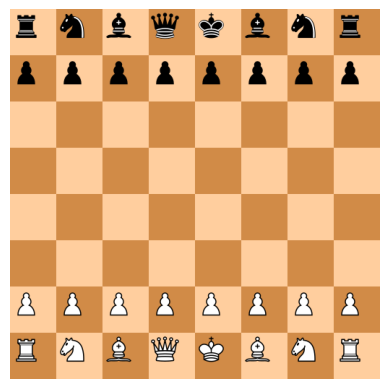

In [ ]:
print_board(initial_game_state)

## PERFT

https://www.chessprogramming.org/Perft_Results#Initial_Position

In [ ]:
def perft(game_state, depth, color):
    """
    state: list of game state bitboards
    depth: amount of moves that will be calculated
    color: starting color
    """
    
    # generate pseudo-legal moves
    plms = move_generator(game_state, color)
    
    # turn pseudo-legal moves into legal moves
    lms = pseudo_to_legal(plms, game_state, color)
    print("depth: 1, moves: " + str(len(lms)))
    
    if color == 0:
        oppo_color = 1
    else:
        oppo_color = 0
        
    captures = 0
    checks = 0
    castlings = 0
                
    for s in lms:
        # check for captures
        if bin(get_occupancy(s)).count("1") != bin(get_occupancy(game_state)).count("1"):
            captures += 1
        # check for checks
        if check_checker(s, oppo_color):
            checks += 1
        if ((s[1] != game_state[1]) & (s[5] != game_state[5])):
            castlings += 1
        #print_board(s)
 
        
    print("captures: " + str(captures))
    print("checks: " + str(checks))
    print("castlings: " + str(castlings))
    print("---------------------------")
    ###########################
    
    # iterate for desired depth
    for i in range(depth - 1):
        # switch color
        if color == 0:
            color = 1
        else:
            color = 0
            
        #################
        captures = 0
        checks = 0
        mate  = 0
        castling = 0
        c0 = 0
        c1 = 0
        c2 = 0
        ##################
                
        # iterate over all states
        new_lms = []
        
        for state in lms: 
            # calculate new states
            #print(state)
            plms = move_generator(state, color)
            part_lms = pseudo_to_legal(plms, state, color)
            
            cast = 0
            
            ###########################
            if color == 0:
                oppo_color = 1
            else:
                oppo_color = 0
                
            if len(part_lms) == 0:
                #print("checkmate")
                mate += 1
                
            for s in part_lms:
                c = False
                # check for captures
                if bin(get_occupancy(s)).count("1") < bin(get_occupancy(state)).count("1"):
                    captures += 1
                    c = True
                    # check who captured
                    plms[]

                if bin(get_occupancy(s)).count("1") > bin(get_occupancy(state)).count("1"):
                    #increase += 1
                    print("increase")
                    print_board(s)
                # check for checks
                if check_checker(s, oppo_color):
                    checks += 1
                # check for castling
                if ((s[1 + color*6] != state[1 + color*6]) & (s[5 + color*6] != state[5 + color*6])):
                    castling += 1
                    cast += 1
                    if c:
                        print("capturing whilst castling")
                        print_board(state)
                        print_board(s)
                
            if cast == 0:
                c0 += 1
            elif cast == 1:
                c1 += 1
            elif cast == 2:
                c2 += 1
            
            new_lms += part_lms
        lms = new_lms
            
        print("depth: " + str(i + 2) + ", moves: " + str(len(lms)))
        print("captures: " + str(captures))
        print("checks: " + str(checks))
        print("mates: " + str(mate))
        print("castling: " + str(castling))
        print("-------------------------")


In [ ]:
perft(initial_game_state, 3, 0)

depth: 1, moves: 20
captures: 0
checks: 0
castlings: 0
---------------------------
depth: 2, moves: 400
captures: 0
checks: 0
mates: 0
castling: 0
-------------------------
depth: 3, moves: 8902
captures: 34
checks: 12
mates: 0
castling: 0
-------------------------


In [ ]:
white_pawn = int('0000000000000000000000000001000000001000000000001110011100000000', 2)
white_rook = int('1000000100000000000000000000000000000000000000000000000000000000', 2)
white_knight = int('0000000000000000000001000000000000010000000000000000000000000000', 2)
white_bishop = int('0000000000011000000000000000000000000000000000000000000000000000', 2)
white_queen = int('0000000000000000001000000000000000000000000000000000000000000000', 2)
white_king = int('0001000000000000000000000000000000000000000000000000000000000000', 2)
print(white_pawn)
print(white_rook)
print(white_knight)
print(white_bishop)
print(white_queen)
print(white_king)

# black
black_pawn = int('0000000000000000100000000000001000000000010100000010110100000000', 2)
black_rook = int('0000000000000000000000000000000000000000000000000000000010000001', 2)
black_knight = int('0000000000000000000000000000000000000000001000100000000000000000', 2)
black_bishop = int('0000000000000000000000000000000000000000000000010100000000000000', 2)
black_queen = int('0000000000000000000000000000000000000000000000000001000000000000', 2)
black_king = int('0000000000000000000000000000000000000000000000000000000000010000', 2)
print('----------------------')
print(black_pawn)
print(black_rook)
print(black_knight)
print(black_bishop)
print(black_queen)
print(black_king)

68853753600
9295429630892703744
4398314946560
6755399441055744
35184372088832
1152921504606846976
----------------------
140746083544320
129
2228224
81920
4096
16


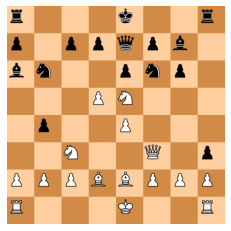

In [ ]:
#kiwipete
white_pawn = int('0000000011100111000000000001000000001000000000000000000000000000', 2)
white_rook = int('1000000100000000000000000000000000000000000000000000000000000000', 2)
white_knight = int('0000000000000000000001000000000000010000000000000000000000000000', 2)
white_bishop = int('0000000000011000000000000000000000000000000000000000000000000000', 2)
white_queen = int('0000000000000000001000000000000000000000000000000000000000000000', 2)
white_king = int('0001000000000000000000000000000000000000000000000000000000000000', 2)

# black
black_pawn = int('0000000000000000100000000000001000000000010100000010110100000000', 2)
black_rook = int('0000000000000000000000000000000000000000000000000000000010000001', 2)
black_knight = int('0000000000000000000000000000000000000000001000100000000000000000', 2)
black_bishop = int('0000000000000000000000000000000000000000000000010100000000000000', 2)
black_queen = int('0000000000000000000000000000000000000000000000000001000000000000', 2)
black_king = int('0000000000000000000000000000000000000000000000000000000000010000', 2)

# en passant
white_en_passant = 0
black_en_passant = 0

# castling_rights
white_long_castle = True
white_short_castle = True
black_long_castle = True
black_short_castle = True

kiwipete = [white_pawn, white_rook, white_knight, white_bishop, white_queen, white_king, black_pawn, black_rook, black_knight, black_bishop, black_queen, black_king, white_en_passant, black_en_passant, white_long_castle, white_short_castle, black_long_castle, black_short_castle]

print_board(kiwipete)

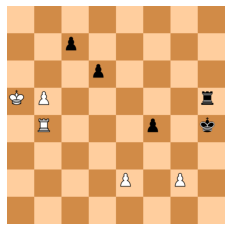

In [107]:
#position 3
white_pawn = int('0000000001010000000000000000000000000010000000000000000000000000', 2)
white_rook = int('0000000000000000000000000000001000000000000000000000000000000000', 2)
white_knight = int('0000000000000000000000000000000000000000000000000000000000000000', 2)
white_bishop = int('0000000000000000000000000000000000000000000000000000000000000000', 2)
white_queen = int('0000000000000000000000000000000000000000000000000000000000000000', 2)
white_king = int('0000000000000000000000000000000000000001000000000000000000000000', 2)

# black
black_pawn = int('0000000000000000000000000010000000000000000010000000010000000000', 2)
black_rook = int('0000000000000000000000000000000010000000000000000000000000000000', 2)
black_knight = int('0000000000000000000000000000000000000000000000000000000000000000', 2)
black_bishop = int('0000000000000000000000000000000000000000000000000000000000000000', 2)
black_queen = int('0000000000000000000000000000000000000000000000000000000000000000', 2)
black_king = int('0000000000000000000000001000000000000000000000000000000000000000', 2)

# en passant
white_en_passant = 0
black_en_passant = 0

# castling_rights
white_long_castle = False
white_short_castle = False
black_long_castle = False
black_short_castle = False

p3 = [white_pawn, white_rook, white_knight, white_bishop, white_queen, white_king, black_pawn, black_rook, black_knight, black_bishop, black_queen, black_king, white_en_passant, black_en_passant, white_long_castle, white_short_castle, black_long_castle, black_short_castle]

print_board(p3)

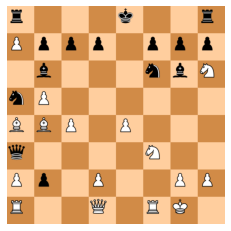

In [106]:
# position 4
# white
white_pawn = int('0000000011001001000000000001010000000010000000000000000100000000', 2)
white_rook = int('0010000100000000000000000000000000000000000000000000000000000000', 2)
white_knight = int('0000000000000000001000000000000000000000100000000000000000000000', 2)
white_bishop = int('0000000000000000000000000000001100000000000000000000000000000000', 2)
white_queen = int('0000100000000000000000000000000000000000000000000000000000000000', 2)
white_king = int('0100000000000000000000000000000000000000000000000000000000000000', 2)

# black
black_pawn = int('0000000000000010000000000000000000000000000000001110111000000000', 2)
black_rook = int('0000000000000000000000000000000000000000000000000000000010000001', 2)
black_knight = int('0000000000000000000000000000000000000001001000000000000000000000', 2)
black_bishop = int('0000000000000000000000000000000000000000010000100000000000000000', 2)
black_queen = int('0000000000000000000000010000000000000000000000000000000000000000', 2)
black_king = int('0000000000000000000000000000000000000000000000000000000000010000', 2)

# en passant
white_en_passant = 0
black_en_passant = 0

# castling_rights
white_long_castle = False
white_short_castle = False
black_long_castle = True
black_short_castle = True

p4 = [white_pawn, white_rook, white_knight, white_bishop, white_queen, white_king, black_pawn, black_rook, black_knight, black_bishop, black_queen, black_king, white_en_passant, black_en_passant, white_long_castle, white_short_castle, black_long_castle, black_short_castle]

print_board(p4)

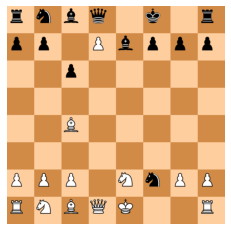

In [105]:
# position 5
# white
white_pawn = int('0000000011000111000000000000000000000000000000000000100000000000', 2)
white_rook = int('1000000100000000000000000000000000000000000000000000000000000000', 2)
white_knight = int('0000001000010000000000000000000000000000000000000000000000000000', 2)
white_bishop = int('0000010000000000000000000000010000000000000000000000000000000000', 2)
white_queen = int('0000100000000000000000000000000000000000000000000000000000000000', 2)
white_king = int('0001000000000000000000000000000000000000000000000000000000000000', 2)

# black
black_pawn = int('0000000000000000000000000000000000000000000001001110001100000000', 2)
black_rook = int('0000000000000000000000000000000000000000000000000000000010000001', 2)
black_knight = int('0000000000100000000000000000000000000000000000000000000000000010', 2)
black_bishop = int('0000000000000000000000000000000000000000000000000001000000000100', 2)
black_queen = int('0000000000000000000000000000000000000000000000000000000000001000', 2)
black_king = int('0000000000000000000000000000000000000000000000000000000000100000', 2)

# en passant
white_en_passant = 0
black_en_passant = 0

# castling_rights
white_long_castle = True
white_short_castle = True
black_long_castle = False
black_short_castle = False

p5 = [white_pawn, white_rook, white_knight, white_bishop, white_queen, white_king, black_pawn, black_rook, black_knight, black_bishop, black_queen, black_king, white_en_passant, black_en_passant, white_long_castle, white_short_castle, black_long_castle, black_short_castle]

print_board(p5)

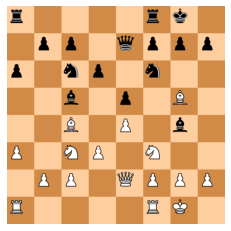

In [104]:
# position 6
# white
white_pawn = int('0000000011100110000010010001000000000000000000000000000000000000', 2)
white_rook = int('0010000100000000000000000000000000000000000000000000000000000000', 2)
white_knight = int('0000000000000000001001000000000000000000000000000000000000000000', 2)
white_bishop = int('0000000000000000000000000000010001000000000000000000000000000000', 2)
white_queen = int('0000000000010000000000000000000000000000000000000000000000000000', 2)
white_king = int('0100000000000000000000000000000000000000000000000000000000000000', 2)

# black
black_pawn = int('0000000000000000000000000000000000010000000010011110011000000000', 2)
black_rook = int('0000000000000000000000000000000000000000000000000000000000100001', 2)
black_knight = int('0000000000000000000000000000000000000000001001000000000000000000', 2)
black_bishop = int('0000000000000000000000000100000000000100000000000000000000000000', 2)
black_queen = int('0000000000000000000000000000000000000000000000000001000000000000', 2)
black_king = int('0000000000000000000000000000000000000000000000000000000001000000', 2)

# en passant
white_en_passant = 0
black_en_passant = 0

# castling_rights
white_long_castle = False
white_short_castle = False
black_long_castle = False
black_short_castle = False

p6 = [white_pawn, white_rook, white_knight, white_bishop, white_queen, white_king, black_pawn, black_rook, black_knight, black_bishop, black_queen, black_king, white_en_passant, black_en_passant, white_long_castle, white_short_castle, black_long_castle, black_short_castle]

print_board(p6)

## Perft checking

In [102]:
perft(kiwipete, 4, 0)

depth: 1, moves: 48
captures: 8
checks: 0
castlings: 2
---------------------------
depth: 2, moves: 2039
captures: 351
checks: 3
mates: 0
castling: 91
-------------------------
depth: 3, moves: 97862
captures: 17102
checks: 993
mates: 0
castling: 3162
-------------------------
depth: 4, moves: 4085603
captures: 757163
checks: 25523
mates: 1
castling: 128013
-------------------------


In [113]:
perft(p3, 5, 0)

depth: 1, moves: 14
captures: 1
checks: 2
castlings: 0
---------------------------
depth: 2, moves: 191
captures: 14
checks: 10
mates: 0
castling: 0
-------------------------
depth: 3, moves: 2812
captures: 209
checks: 267
mates: 0
castling: 0
-------------------------
depth: 4, moves: 43238
captures: 3348
checks: 1680
mates: 0
castling: 0
-------------------------
depth: 5, moves: 674624
captures: 52051
checks: 52950
mates: 17
castling: 0
-------------------------


In [109]:
perft(p4, 4, 0)

depth: 1, moves: 6
captures: 0
checks: 0
castlings: 0
---------------------------
depth: 2, moves: 264
captures: 87
checks: 10
mates: 0
castling: 6
-------------------------
depth: 3, moves: 9467
captures: 1021
checks: 38
mates: 0
castling: 0
-------------------------
depth: 4, moves: 422333
captures: 131393
checks: 15492
mates: 22
castling: 7795
-------------------------


In [110]:
perft(p5, 4, 0)

depth: 1, moves: 44
captures: 6
checks: 0
castlings: 1
---------------------------
depth: 2, moves: 1486
captures: 222
checks: 117
mates: 0
castling: 0
-------------------------
depth: 3, moves: 62379
captures: 8517
checks: 1201
mates: 0
castling: 1081
-------------------------
depth: 4, moves: 2103487
captures: 296153
checks: 158486
mates: 44
castling: 0
-------------------------


In [111]:
perft(p6, 4, 0)

depth: 1, moves: 46
captures: 4
checks: 1
castlings: 0
---------------------------
depth: 2, moves: 2079
captures: 203
checks: 40
mates: 0
castling: 0
-------------------------
depth: 3, moves: 89890
captures: 9470
checks: 1783
mates: 0
castling: 0
-------------------------
depth: 4, moves: 3894594
captures: 440388
checks: 68985
mates: 0
castling: 0
-------------------------


## Debugging

In [74]:
def divide4(game_state, color):
    """
    state: list of game state bitboards
    depth: amount of moves that will be calculated
    color: starting color
    """
    # generate pseudo-legal moves
    plms = move_generator(game_state, color)
    # turn pseudo-legal moves into legal moves
    lms = pseudo_to_legal(plms, game_state, color)
    print("depth: 1, moves: " + str(len(lms)))
    
    # calculate for each move
    for state in lms: 
        nodes = 0
        # calculate new states
        plms = move_generator(state, 1)
        new_lms = pseudo_to_legal(plms, state, 1)
        for s1 in new_lms:
            # calculate new states
            plms = move_generator(s1, 0)
            new_new_lms = pseudo_to_legal(plms, s1, 0)
            for s2 in new_new_lms:
                # calculate new states
                plms = move_generator(s2, 1)
                newest_lms = pseudo_to_legal(plms, s2, 1)
                
                nodes += len(newest_lms)
                
        print("nodes: " + str(nodes))
        if nodes == 90984:
            print_board(state)
            kiwipete1 = state
            break
            
    return kiwipete1
            

depth: 1, moves: 48
nodes: 79551
nodes: 97464
nodes: 90984


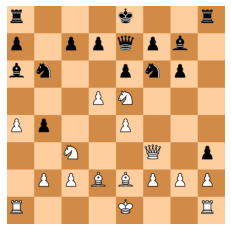

In [75]:
kiwipete1 = divide4(kiwipete, 0)

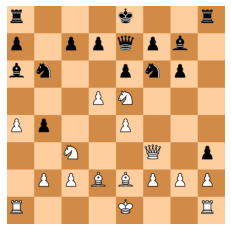

In [76]:
#kiwipete 1
print_board(kiwipete1)
#FEN (from Nibbler): r3k2r/p1ppqpb1/bn2pnp1/3PN3/Pp2P3/2N2Q1p/1PPBBPPP/R3K2R b KQkq a3 0 1
# a2 a4

In [81]:
def divide3(game_state, color):
    """
    state: list of game state bitboards
    depth: amount of moves that will be calculated
    color: starting color
    """
    # generate pseudo-legal moves
    plms = move_generator(game_state, color)
    # turn pseudo-legal moves into legal moves
    lms = pseudo_to_legal(plms, game_state, color)
    print("depth: 1, moves: " + str(len(lms)))
    
    # calculate for each move
    for state in lms: 
        nodes = 0
        # calculate new states
        plms = move_generator(state, 0)
        new_lms = pseudo_to_legal(plms, state, 0)
        for s1 in new_lms:
            # calculate new states
            plms = move_generator(s1, 1)
            new_new_lms = pseudo_to_legal(plms, s1, 1)

            nodes += len(new_new_lms)
                
        print("nodes: " + str(nodes))
        if nodes == 2027:
            print_board(state)
            kiwipete2 = state
            break

    return kiwipete2

depth: 1, moves: 44
nodes: 2123
nodes: 2027


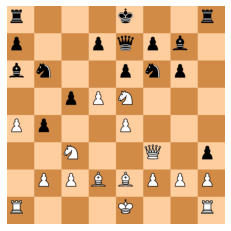

In [82]:
kiwipete2 = divide3(kiwipete1, 1)

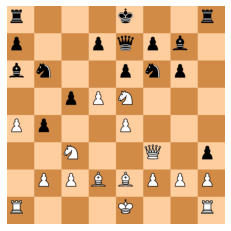

In [83]:
#kiwipete 2
print_board(kiwipete2)
#FEN (from Nibbler): r3k2r/p2pqpb1/bn2pnp1/2pPN3/Pp2P3/2N2Q1p/1PPBBPPP/R3K2R w KQkq c6 0 2
# a2 a4
# c7 c5
# should have been 2025, i got 2027 (I still have 4 additional extra moves outside of this path)

In [95]:
def divide2(game_state, color):
    """
    state: list of game state bitboards
    depth: amount of moves that will be calculated
    color: starting color
    """
    # generate pseudo-legal moves
    plms = move_generator(game_state, color)
    # turn pseudo-legal moves into legal moves
    lms = pseudo_to_legal(plms, game_state, color)
    print("depth: 1, moves: " + str(len(lms)))
    
    # calculate for each move
    for state in lms: 
        nodes = 0
        # calculate new states
        plms = move_generator(state, 1)
        new_lms = pseudo_to_legal(plms, state, 1)
        
        nodes += len(new_lms)
                
        print("nodes: " + str(nodes))
        if nodes == 42:
            print_board(state)
            kiwipete3 = state
            
    return kiwipete3



depth: 1, moves: 50
nodes: 42


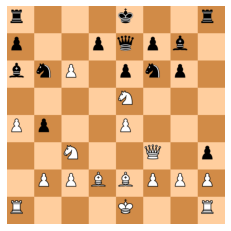

nodes: 39
nodes: 44
nodes: 41
nodes: 40
nodes: 40
nodes: 40
nodes: 41
nodes: 42


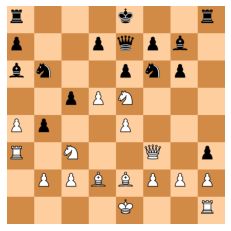

nodes: 41
nodes: 41
nodes: 41
nodes: 41
nodes: 41
nodes: 41
nodes: 43
nodes: 42


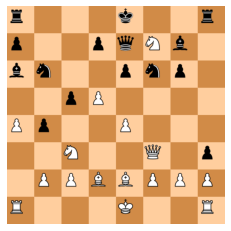

nodes: 41
nodes: 40
nodes: 39
nodes: 42


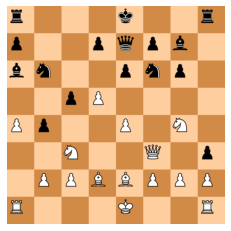

nodes: 41
nodes: 37
nodes: 40
nodes: 40
nodes: 40
nodes: 39
nodes: 40
nodes: 41
nodes: 41
nodes: 41
nodes: 34
nodes: 37
nodes: 38
nodes: 40
nodes: 42


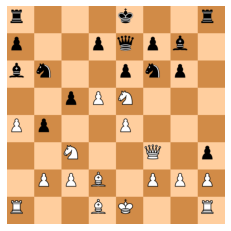

nodes: 42


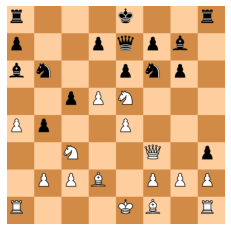

nodes: 37
nodes: 43
nodes: 41
nodes: 41
nodes: 41
nodes: 40
nodes: 41
nodes: 41
nodes: 41
nodes: 41
nodes: 41
nodes: 42


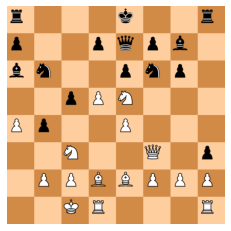

nodes: 42


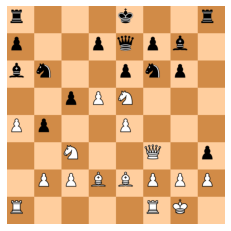

In [96]:
kiwipete3 = divide2(kiwipete2, 0)
# 2 moves too many with 42 follow-ups
#d5c6
#a1a3
#e5f7
#e5g4
#e2d1
#e2f1

#the castling ones are the problem!!!!!!!!!!!!!!!!!!!!!!!!

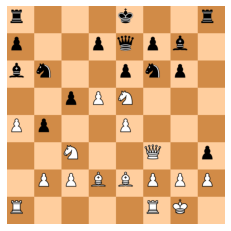

depth: 1, moves: 42
capture


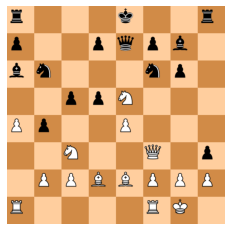

capture


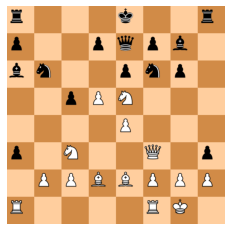

capture


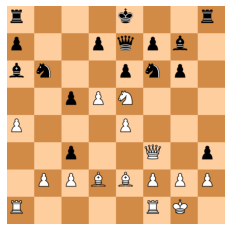

capture


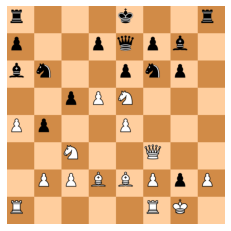

capture


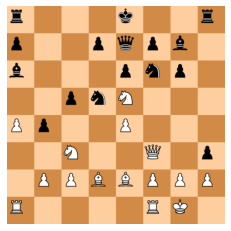

capture


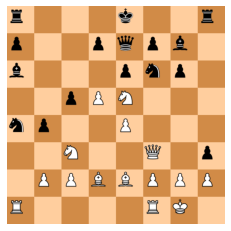

capture


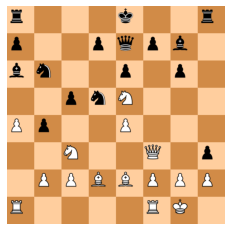

capture


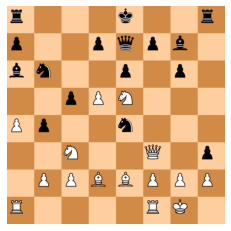

capture


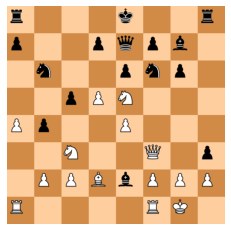

captures: 9
checks: 0
castlings: 0
---------------------------


In [99]:
# kiwipete3
print_board(kiwipete3)
gs = kiwipete3
color = 1

# generate pseudo-legal moves
plms = move_generator(gs, color)
# turn pseudo-legal moves into legal moves
lms = pseudo_to_legal(plms, gs, color)
print("depth: 1, moves: " + str(len(lms)))
    
################################
if color == 0:
    oppo_color = 1
else:
    oppo_color = 0

captures = 0
checks = 0
castlings = 0

for s in lms:
    # check for captures
    if bin(get_occupancy(s)).count("1") != bin(get_occupancy(gs)).count("1"):
        captures += 1
        print("capture")
        print_board(s)
    # check for checks
    if check_checker(s, oppo_color):
        checks += 1
    if ((s[1] != gs[1]) & (s[5] != gs[5])):
        castlings += 1
    #print_board(s)


print("captures: " + str(captures))
print("checks: " + str(checks))
print("castlings: " + str(castlings))
print("---------------------------")

# issue with en passant right after castling???

# the en passant capture is illegal!!!